In the context of the dataset from the Nasdaq Stock Exchange, involves several key elements as indicated by the features in the data. following of these elements can influence stock prices.

### Bid Price and Ask Price:
Bid price: the highest price a buyer is willing to pay for a stock
Ask price: the lowest price a seller is willing to accept.

The difference between these two is known as the bid-ask spread.

### Bid size and Ask size:
Bid size: the amount buyers are willing to purchase at the bid price.
Ask size: the amount sellers are willing to sell at the ask price.

### Imbalance Size and Imbalance Buy/Sell Flag:
1. This represents the unmatched amount at the current reference price.
2. The flag indicates whether the imbalance is on the buy side, sell side, or there is no imbalance.
3. A large imbalance can suggest a potential shift in the stock price if there's more demand(buy-side imbalance) or supply(sell-side imbalance) than the market can absort at the current price.

### Reference Price:
1. This is typically the price at which paied shares are maximized, the imbalance is minimized, and the distance from the bid-ask midpoint is minimized.
2. It serves as a benchmark for evaluating the potential for a stock price movement.

### Matched Size:
1. This is the amount that can be matched at the current reference price.
2. It provides insight into the volumne of stock that can be transacted without causing significant price changes.

### Far Price and Near Price
1. Far price: The price maximizing the number of shares matched based on auction interest only.
2. Near Price: The price maximizing the number of shares matched based on both auction and continouts market orders.
3. These prices give an indication of where the market could clear in high volumn transactions.

### Weighted Average Price (WAP):
1. This is a calculation of the average price of a security, weighted by the volumn of transactions at each price point.
2. It provides a more accurate reflection of the market trend than simply averageing the trade prices.

### Time-based aspects:
1. Seconds in Bucket: Number of seconds elapsed since the beginning of the day's closing auction. This temporal aspect can capture intraday volatility.
2. Time ID: A unique identifier representing a specific time, useful for time-series analysis.

### Identifiers (Stock ID, Date ID, Row ID):
while these do not directly influence stock prices, they are crucial for data organiz

In [1]:
! pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import optuna
import xgboost as xgb  # Importing XGBoost here
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

### Data Preprocessing:

the code below:
1. Missing values are first forward-filled and then any remaining NaNs are filled with zero.
2. The specified numerical features are scaled using 'StandardScaler'
3. The 'stock_od' is treated as a categorical feature and is encoded using label encoding.
4. A new feature, 'wap_rolling_avg', is created as the rolling average of the 'wap' feature over window of. This could be changed to another feature if 'wap' is not the most relevant for rolling averages.

In [4]:
from sklearn.model_selection import train_test_split

# Replace file paths with your actual file paths
df_train = pd.read_csv('train.csv')

df_train, df_test = train_test_split(df_train, test_size=0.1, random_state=42)


# Handling Missing Values
# Forward fill followed by filling any remaining NaNs with zeros
df_train.fillna(method='ffill', inplace=True)
df_train.fillna(0, inplace=True)

# Feature Scaling
# Scaling the identified numerical features
numerical_features = [
    'seconds_in_bucket', 'imbalance_size', 'reference_price',
    'matched_size', 'far_price', 'near_price', 'bid_price',
    'ask_price', 'bid_size', 'ask_size', 'wap'
]
scaler = StandardScaler()
df_train[numerical_features] = scaler.fit_transform(df_train[numerical_features])

# Encoding Categorical Variables
# Encoding 'stock_id' as it is a categorical variable
df_train['stock_id'] = df_train['stock_id'].astype('category').cat.codes

# Creating New Features
# Example: Rolling average of the 'wap' feature
df_train['wap_rolling_avg'] = df_train.groupby('stock_id')['wap'].rolling(window=5).mean().reset_index(level=0, drop=True)


################################################################################################################################################################
################################################################################################################################################################
################################################################################################################################################################

# Handling Missing Values
# Forward fill followed by filling any remaining NaNs with zeros
df_test.fillna(method='ffill', inplace=True)
df_test.fillna(0, inplace=True)

# Feature Scaling
# Scaling the identified numerical features
numerical_features = [
    'seconds_in_bucket', 'imbalance_size', 'reference_price',
    'matched_size', 'far_price', 'near_price', 'bid_price',
    'ask_price', 'bid_size', 'ask_size', 'wap'
]
scaler = StandardScaler()
df_test[numerical_features] = scaler.fit_transform(
    df_test[numerical_features])

# Encoding Categorical Variables
# Encoding 'stock_id' as it is a categorical variable
df_test['stock_id'] = df_test['stock_id'].astype('category').cat.codes

# Creating New Features
# Example: Rolling average of the 'wap' feature
df_test['wap_rolling_avg'] = df_test.groupby('stock_id')['wap'].rolling(
    window=5).mean().reset_index(level=0, drop=True)

## Feature Engineering

Feature engineering is a crucial step in data preprocessing, especially in complex domains like stock market analysis. It involves creating new features from the existing data to better capture the underlying patterns and relationships, ultimately improving the model's performance.

### 1. Imbalance Ratios:

#### Imbalance to Matched ratio:
This ratio represents the proportion of unmatched order to matched orders at the current price. A higher ratio could indicate more significant market imbalance, which might be predictive of future price movements.
#### Bid to Ask Ratio:
The ratio of the total size of bids to the total size of asks. This can be an indicator of supply and demand dynamics. Ahigher ratio might suggest higher demand comapred to supply, potentially affecting the stock's future price.

### 2.Price Ratios and differences
#### Bid-Ask Price Difference:
This is the difference between the ask price(price to sell) and the bid price(price to buy). A wider spread can indicate lower liquidity of higher transaction costs.
#### Bid to Ask Price Ratio:
Similar to the bid-ask ratio in terms of quantities, this ration in terms of price can give insights into the relatives positioning of buyers and sellers.

### 3.Time Features
#### Minute in Bucket and Second in Bucket:
These features break down the 'seconds_in_bucket' into minutes and seconds. They can help the model capture patterns occurring at specific times within each minutes.

### 4. Rolling Window Feature
#### Rolling Mean of WAP(Weighted Average Price):
This feature captures the average price over a window. It helps in understanding the short-term trend and smoothing out fluctuations. This could be particularly useful in capturing momentum or mean reversion effects in stock prices.

In [5]:
# 1. Imbalance Ratios
df_train['imbalance_to_matched_ratio'] = df_train['imbalance_size'] / df_train['matched_size']

# 2. Imbalance size

# -----> referecned from https://www.kaggle.com/code/bekhzodortikov/simple-baseline-xgboost-model-for-beginners
df_train['imblance_size1'] = (df_train['bid_size'] - df_train['ask_size']) / (df_train['bid_size'] + df_train['ask_size'])
df_train['imbalance_size2'] = (df_train['imbalance_size'] - df_train['matched_size']) / (df_train['imbalance_size'] + df_train['matched_size'])



df_train['bid_to_ask_price_ratio'] = df_train['bid_price'] / df_train['ask_price']
df_train['bid_to_ask_ratio'] = df_train['bid_size'] / df_train['ask_size']

# -----> refereced from https://www.kaggle.com/code/bekhzodortikov/simple-baseline-xgboost-model-for-beginners
df_train['price_difference'] = df_train['reference_price'] = df_train['wap']
df_train['bid_ask_price_diff'] = df_train['bid_price'] - df_train['ask_price']
df_train['mid_price'] = (df_train['ask_price'] + df_train['bid_price']) / 2
df_train['bid_plus_ask_sizes'] = df_train['bid_size'] + df_train['ask_size']


# 3. Time Features
df_train['minute_in_bucket'] = df_train['seconds_in_bucket'] // 60
df_train['second_in_bucket'] = df_train['seconds_in_bucket'] % 60

# 4. Example of a Rolling Window Feature (e.g., rolling mean of wap over the past 3 entries)
# Note: This requires sorting by time and potentially grouping by stock_id or date_id
df_train['wap_rolling_mean_3'] = df_train.sort_values(by=['date_id', 'seconds_in_bucket'])\
                                                        .groupby(['stock_id'])['wap']\
                                                        .rolling(window=3, min_periods=1)\
                                                        .mean()\
                                                        .reset_index(level=0, drop=True)


################################################################################################################################################################
################################################################################################################################################################
################################################################################################################################################################

# 1. Imbalance Ratios
df_test['imbalance_to_matched_ratio'] = df_test['imbalance_size'] / \
    df_test['matched_size']

# 2. Imbalance size

# -----> referecned from https://www.kaggle.com/code/bekhzodortikov/simple-baseline-xgboost-model-for-beginners
df_test['imblance_size1'] = (
    df_test['bid_size'] - df_test['ask_size']) / (df_test['bid_size'] + df_test['ask_size'])
df_test['imbalance_size2'] = (df_test['imbalance_size'] - df_test['matched_size']) / \
    (df_test['imbalance_size'] + df_test['matched_size'])


df_test['bid_to_ask_price_ratio'] = df_test['bid_price'] / \
    df_test['ask_price']
df_test['bid_to_ask_ratio'] = df_test['bid_size'] / df_test['ask_size']

# -----> refereced from https://www.kaggle.com/code/bekhzodortikov/simple-baseline-xgboost-model-for-beginners
df_test['price_difference'] = df_test['reference_price'] = df_test['wap']
df_test['bid_ask_price_diff'] = df_test['bid_price'] - df_test['ask_price']
df_test['mid_price'] = (df_test['ask_price'] + df_test['bid_price']) / 2
df_test['bid_plus_ask_sizes'] = df_test['bid_size'] + df_test['ask_size']


# 3. Time Features
df_test['minute_in_bucket'] = df_test['seconds_in_bucket'] // 60
df_test['second_in_bucket'] = df_test['seconds_in_bucket'] % 60

# 4. Example of a Rolling Window Feature (e.g., rolling mean of wap over the past 3 entries)
# Note: This requires sorting by time and potentially grouping by stock_id or date_id
df_test['wap_rolling_mean_3'] = df_test.sort_values(by=['date_id', 'seconds_in_bucket'])\
    .groupby(['stock_id'])['wap']\
    .rolling(window=3, min_periods=1)\
    .mean()\
    .reset_index(level=0, drop=True)



## Explanation of why we are using these features

#### 1. Imbalanced to Matched Ratio
This ratio provides insight into the relative size of the unmatched orders at the current price level compared to those that can be matched. A higher ratio might indicate greater market imbalance, which could lead to more significant price movements, thus being predictive of future price changes.

#### 2. Imbalance_size1 and imbalance_size2
Imblance_size1: measures net imbalance between buy and sell orders in the order book, normalized by the total order size. This can indicate whether there's a dominance of buy or sell pressure.

Imbalance_size2: looks at the difference between the auction imbalance size and the matched size, again normalized. This could highlight discrepancies between what's currently on the order book and what's happening in the auction, which might signal impending price movement.

#### 3. Bid to Ask Price and Size Ratios
bid_to_ask_price_ratio: this gives an indication of the relative positioning of buyers and sellers in the market. A higher or lower ratio could signal a shift in market sentiment.

bid_to_ask_ratio: this is the size ratio provides a sense of the balance or imbalance between buy and sell orders, which is crucial factor in determining market dynamics and potential price movements.

#### 4. Prices differences
price_difference: compares the reference price to the weighted average price(wap_, potentially signaling how far the current price deviates from the average.

bid_ask_price_diff: is the direct difference between bid and ask prices, an essential measure of market liquidity and spread.

mid_price: calculates the average of bid and ask prices, often considered as a fair value of the stock at that moment.

#### 5. Total Bid and Ask Sizes
bid_plus_ask_sizes: The sum of bid and ask sizes might indicate the overall market activity or liquidity at a given moment, which is important for predicting price movements, especially in a high-frequency trading context.

#### 6. Time Features ('minute_in_bucket', 'second_in_bucket')
These features help capture the temporal aspects of the market, such as how market dynamics might change as the auction progresses. Time-based patterns are often critical in financial markets.

#### 7.Rolling Window Feature
wap_rolling_mean: This feature calculates the rolling average of the weighted average price over a short window. It smooths out short-term fluctuations and provides a sense of the short-term trend or momentum in the stock price.

By integrating these features into your model, XGBoost can then leverage its tree-based structure to identify complex patterns and interactions between these featrues, potentially leading to more accurate prediction and lower MAE.

## 2. XGBoost Regressor Model

XGBoost (eXtreme Gradient Boosting) is highly efficient and scalable implementation of gradient boosing, a machine learning algotirhm that is widely used in regression, calssification, and ranking problems. Here's a detailed explanation of how XGBoost works and the insights:

### Gradient Boosting Framework

XGBoost is based on the gradient boosting framework, which builds models in a stage-wise:

#### 1. Decision Trees as Weak Learners:
 In gradient boosting, the weak learners are decision trees. A decision tree is like a flowchart that makes decisions based on input data. Each decision leads to either another decision or a final prediction.

#### 2. Boosting in Stages:
The model is built in stages, and at each stage, a new tree is added to correct the errors made by the existing sequence of trees. The process involves analyzing the errors from the previous stage and then building a new tree to improve the predictions.

#### 3. Gradient Descent for Error Reduction:
The “gradient” part of gradient boosting is a mathematical method (gradient descent) used to minimize the error in predictions. It's like gradually refining the model to make it better by focusing on areas where it's currently making mistakes.

### Key Features of XGBoost

XGBoost intoduces several advancements that improve performance and accuracy:

#### 1. Regularization:
XGBoost includes L1 Lasso Regression and L2 Ridge Regression regularization terms in the cost function, which prevents overfitting and improves model generalization.

#### 2. Sparsity-Aware Split Finding:
It can handle missing data and is efficient with sparse data (missing values) by proposing a "sparsity-aware" algorithm for split finding, which makes it suitable for scenarios with missing data or zero-inflated datasets.

#### 3. Tree Pruning:
Traditional gradient boosting uses a greedy algorithm that grows trees to a fixed size, but XGBoost uses a depth-first approach that allows for pruning of trees using the max_depth parameter, and it prunes back splits that have a negative gain.

#### 4. Weighted Quantile Sketch:
To efficiently find the best split points, XGBoost uses a distributed weighted quantile sketch algorithm that can handle weighted data.

#### 5. Cross-Validation:
It can perform cross-validation at every iteration of the boosting process, allowing the user to easily obtain the best iteration.

#### 6. Parallel Processing and High Performance:
It is designed to be computationally efficient by utilizing the power of parallel processing (meaning it can run multiple processes at the same time), which makes it faster.

### Algorithmic Insights

XGBoost works by iteratively adding new trees that predict the residuals or errors of the previous tree combined. The learning process can be described in steps:

#### 1. Objective Function:
The objective function of XGBoost includes two parts: the loss function that measures how predictive the model is with respect to the actual data, and the regularization term which controls the model's complexity.

#### 2. Additive Training:
Start with an initial prediction (usually 0.5 for classification, mean of the target for regression), and add new trees that predict the new trees that predict the residuals from the previous trees.

#### 3. Split Finding:
For each tree, determine the best split points on the features. XGBoost uses quantile-based binning and a novel algorithm to efficiently find these split points even in large datasets.

#### 4. Tree Construction:
Trees are constructed in a depth-first manner, and nodes are split until the specified max_depth is reached, or no further splits are possible.

#### 5. Pruning:
After a tree is fully grown, it might get pruned back to the best size based on the gain from each split.

#### 6. Learning Rate:
A learning rate (eta) is used to shrink the feature weights to make the boosting process more conservative and prevent overfitting.

#### 7.Iteration:
This process continues for a specified number of iterations(n_estimators) or until the improvement falls below a threshold.

### Benefits of Using XGBoost

#### 1. Speed and Performance:
XGBoost is designed to be highly efficient, scalable, and portable. It often outperforms other implementations of gradient boosting in terms of speed and model accuracy.

#### 2. Handling Missing Values:
XGBoost has an in-built routine to handle missing values. The user can provide a different value than other entries and XGBoost can learn which path to take for missing values.

#### 3. Feature Importance:
XGBoost provides a straightforward way to visualize the importance of features, helping in understanding the model.

#### 4. Flexibility:
XGBoost allow users to define custom optimization objectives and evaluation criteria, adding a whole new dimension to the model.

#### 5. Hardware Optimization:
XGBoost is optimized for distributed and efficient computing, including support for multi-threading on a single machine and distributed computing on multiple machines.


## 3. Hyperparameter Tuning with Optuna

In XGBoost, the 'eta' parameter, also known as the learning rate, plays a crucial role in controlling the model's learning process. It is one of the key hyperparameters that can significantly impact the performance of the model.

#### 1. Learning Rate:
The 'eta' parameter specifies the step size shrinkage used in updating the weights of the model to prevent overfitting. After each boosting step, it scales the contribution of each tree by 'eta'. It's a value between 0 and 1.

#### 2.Model Convergence:
1. A smaller 'eta' value means the model makes more conservative updates. This leads to more robust models, as it requires more trees to converge, reducing the risk of overfitting. However, it can also mean longer training times and may require more trees to learn the underlying patterns effectively.

2. A larger eta makes the model learn faster, requiring fewer trees to achieve similar performance levels. But this can lead to a more aggressive learning that can overshoot the optimal solutions and potentially cause overfitting.

#### 3. Trade-off Between 'eta' and 'n_estimators':
1. Typically, there is a trade-off between eta and the number of boosting rounds (n_estimators). A lower learning rate often requires a higher number of trees to model all the interactions properly but is generally more robust.

2. Conversely, a higher learning rate can achieve similar performance with fewer trees but might miss out on finer details in the data.

#### 4. Parameter Tuning:
1. Selecting the right eta is crucial and often done via hyperparameter tuning (e.g., using grid search, random search, or Bayesian optimization methods like Optuna).

2. It's common to start with a higher learning rate to quickly identify a promising area in the parameter space and then fine-tune the model with a lower learning rate for more subtle improvements.

#### 5.Interaction with Other Parameters:
1. The effectiveness of eta can also depend on other hyperparameters, like max_depth (depth of the trees), min_child_weight (minimum sum of instance weight needed in a child), and regularization parameters.

2. Proper tuning of eta should be done considering the model's overall context, including these other parameters.



In [ ]:
# Assuming df_train is preprocessed and ready for modeling
# Exclude 'row_id' and split features and target
X = df_train.drop(columns=['target', 'row_id'])  # Exclude 'row_id'
y = df_train['target']




# Define the objective function for Optuna
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'eta': trial.suggest_float('eta', 0.01, 0.2),
        # Add more XGBoost parameters here if needed
    }
    model = xgb.XGBRegressor(**param)  # XGBoost model

    # Time-Series Cross-Validation
    tscv = TimeSeriesSplit(n_splits=5)
    mae_scores = []

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Fit the model
        model.fit(X_train, y_train)

        # Evaluate the model
        preds = model.predict(X_test)
        mae_scores.append(mean_absolute_error(y_test, preds))

    # Return the average MAE over all folds
    return np.mean(mae_scores)

# Run Optunaoptimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Best hyperparameters
print("Best trial:", study.best_trial.params)

[I 2023-12-02 04:46:34,943] A new study created in memory with name: no-name-0f2f5829-f019-4da0-944c-9a6f619c2d58
[I 2023-12-02 04:47:12,800] Trial 0 finished with value: 5.054332125484512 and parameters: {'n_estimators': 103, 'max_depth': 6, 'eta': 0.15912366527252236}. Best is trial 0 with value: 5.054332125484512.
[I 2023-12-02 04:49:13,317] Trial 1 finished with value: 4.993274844258472 and parameters: {'n_estimators': 344, 'max_depth': 9, 'eta': 0.022042359545759373}. Best is trial 1 with value: 4.993274844258472.
[I 2023-12-02 04:51:55,346] Trial 2 finished with value: 4.748810843196739 and parameters: {'n_estimators': 215, 'max_depth': 11, 'eta': 0.11622428525880107}. Best is trial 2 with value: 4.748810843196739.
[I 2023-12-02 04:52:07,236] Trial 3 finished with value: 5.114533555078545 and parameters: {'n_estimators': 65, 'max_depth': 6, 'eta': 0.0670337985390157}. Best is trial 2 with value: 4.748810843196739.
[I 2023-12-02 04:52:53,914] Trial 4 finished with value: 4.9503516

Best trial: {'n_estimators': 273, 'max_depth': 12, 'eta': 0.1556875274712052}


In [ ]:

import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")

def lgbm_objective(trial):
    lgbm_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        # Add more LightGBM parameters here
    }
    model = lgb.LGBMRegressor(**lgbm_params,verbose=-1)

    # Time-Series Cross-Validation
    tscv = TimeSeriesSplit(n_splits=5)
    # Repeat the cross-validation process as done for XGBoost
    mae_scores = []
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        mae_scores.append(mean_absolute_error(y_test, preds))

    return np.mean(mae_scores)


# Optimize LightGBM parameters
lgbm_study = optuna.create_study(direction='minimize')
lgbm_study.optimize(lgbm_objective, n_trials=10)

# Output best parameters for LightGBM
print("Best LightGBM trial:", lgbm_study.best_trial.params)

[I 2023-12-02 05:01:13,838] A new study created in memory with name: no-name-b35c11b0-22d9-4857-9812-a5244946228b
[I 2023-12-02 05:01:28,283] Trial 0 finished with value: 5.155555375167446 and parameters: {'n_estimators': 117, 'max_depth': 10, 'learning_rate': 0.012545861594610543}. Best is trial 0 with value: 5.155555375167446.
[I 2023-12-02 05:01:42,540] Trial 1 finished with value: 5.148347036294306 and parameters: {'n_estimators': 206, 'max_depth': 3, 'learning_rate': 0.028839831171039616}. Best is trial 1 with value: 5.148347036294306.
[I 2023-12-02 05:01:57,250] Trial 2 finished with value: 5.114717554655521 and parameters: {'n_estimators': 132, 'max_depth': 11, 'learning_rate': 0.034740423030432614}. Best is trial 2 with value: 5.114717554655521.
[I 2023-12-02 05:02:15,614] Trial 3 finished with value: 5.037341200101089 and parameters: {'n_estimators': 228, 'max_depth': 12, 'learning_rate': 0.09673694191390969}. Best is trial 3 with value: 5.037341200101089.
[I 2023-12-02 05:02:

Best LightGBM trial: {'n_estimators': 228, 'max_depth': 12, 'learning_rate': 0.09673694191390969}


In [6]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

X = df_train.drop(columns=['target', 'row_id'])  # Exclude 'row_id'
y = df_train['target']

# Optimal hyperparameters for XGBoost and LightGBM from the trials
xgb_params = {'n_estimators': 273, 'max_depth': 12, 'eta': 0.1556875274712052}
lgbm_params = {'n_estimators': 228, 'max_depth': 12, 'learning_rate': 0.09673694191390969}

# Train XGBoost model with best parameters
xgb_model = XGBRegressor(**xgb_params)
xgb_model.fit(X, y)

# Train LightGBM model with best parameters
lgbm_model = LGBMRegressor(**lgbm_params, verbose=-1)
lgbm_model.fit(X, y)

LGBMRegressor(learning_rate=0.09673694191390969, max_depth=12, n_estimators=228,
              verbose=-1)

In [7]:
unseen_X = df_test.drop(columns=['target', 'row_id'])  # Exclude 'row_id'
unseen_Y = df_test['target']


# To make predictions and ensemble them:
xgb_preds = xgb_model.predict(unseen_X)
lgbm_preds = lgbm_model.predict(unseen_X)

# Simple averaging ensemble
ensemble_preds = (xgb_preds + lgbm_preds) / 2

# Calculating MAE
mae = np.mean(np.abs(ensemble_preds - unseen_Y))

print(f'Final MAE: {mae}')

Final MAE: 6.322196931664954


## 3. Model Visualization

#### 1. Feature Importance Plot:
XGBoost provides a way to visualize the importance of each feature in your model. This can help you understand which features are most influential in predicting stock price movements. You use a bar chart to display the feature importance scores.

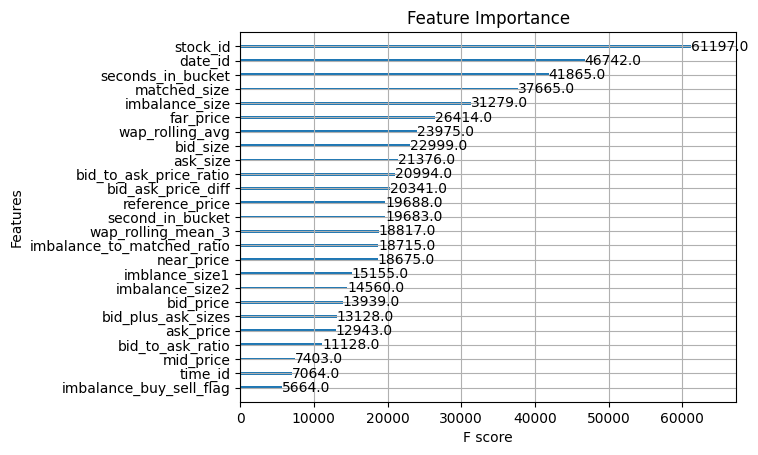

In [8]:
import xgboost as xgb
import matplotlib.pyplot as plt

xgb.plot_importance(xgb_model)
plt.title("Feature Importance")
plt.show()

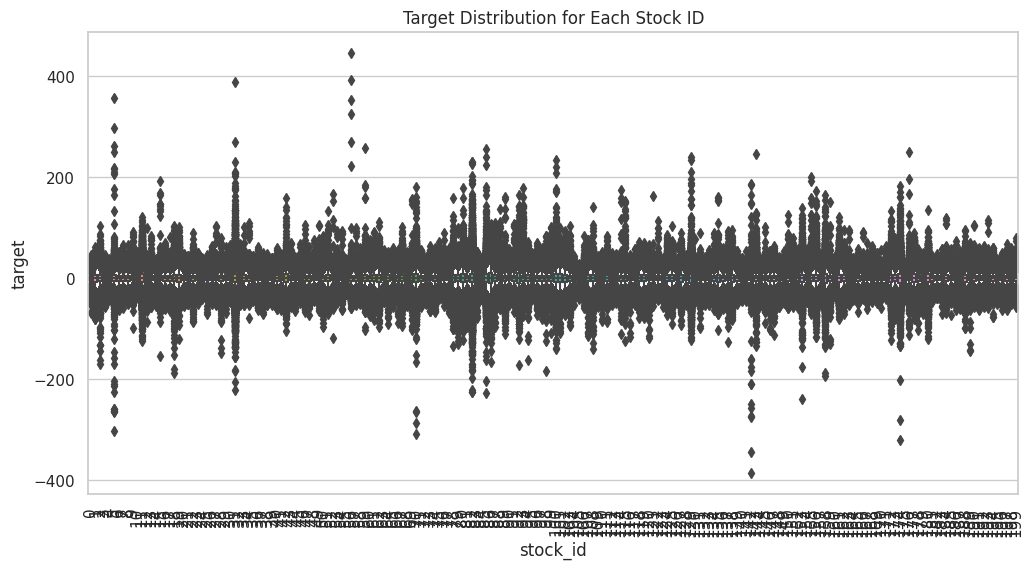

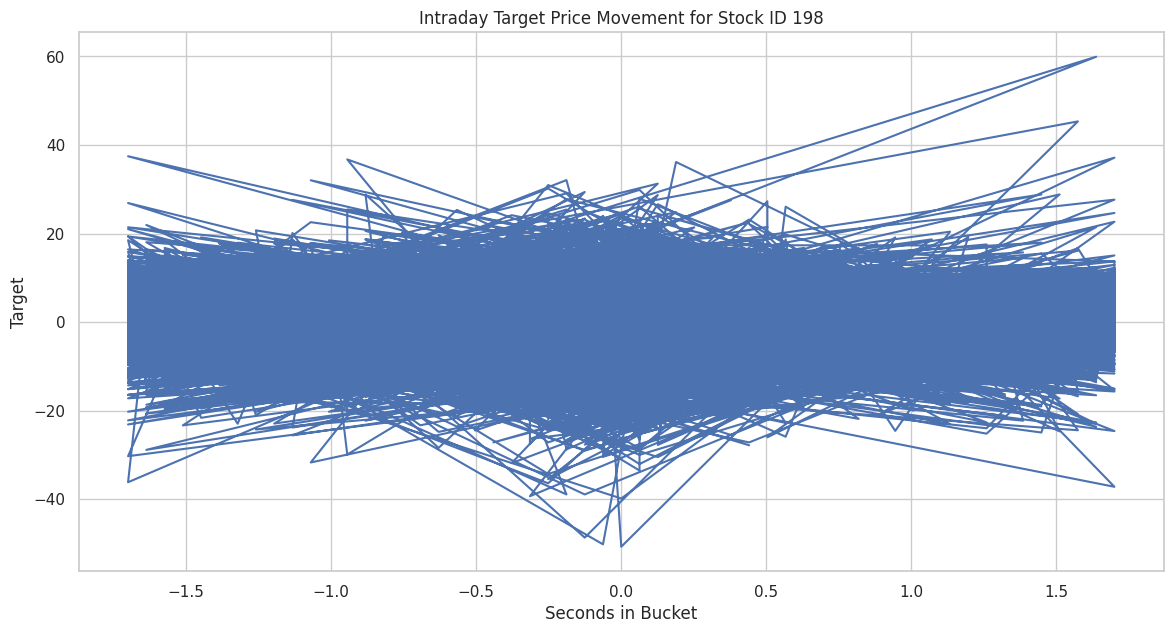

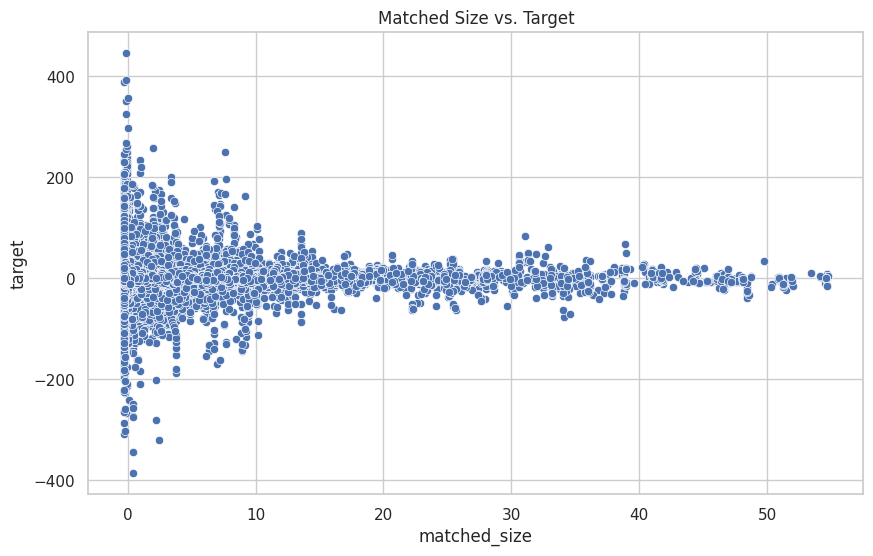

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Let's assume df_train is your original DataFrame that contains the data.
df = df_train.copy()

# Choose a specific stock ID for the time series plot.
# This should be an actual stock_id from your dataset.
some_stock_id = df['stock_id'].unique()[0]  # Replace 0 with the index of the stock_id you want to plot

sns.set(style="whitegrid")

# Boxplot for stock_id vs target
plt.figure(figsize=(12, 6))
sns.boxplot(x='stock_id', y='target', data=df)
plt.title('Target Distribution for Each Stock ID')
plt.xticks(rotation=90)  # Rotate the x labels if there are many stock_ids
plt.show()

# Time series plot for seconds_in_bucket vs target for a specific stock_id
plt.figure(figsize=(14, 7))
specific_stock = df[df['stock_id'] == some_stock_id]
plt.plot(specific_stock['seconds_in_bucket'], specific_stock['target'])
plt.title('Intraday Target Price Movement for Stock ID ' + str(some_stock_id))
plt.xlabel('Seconds in Bucket')
plt.ylabel('Target')
plt.show()

# Scatter plot for matched_size vs target
plt.figure(figsize=(10, 6))
sns.scatterplot(x='matched_size', y='target', data=df)
plt.title('Matched Size vs. Target')
plt.show()


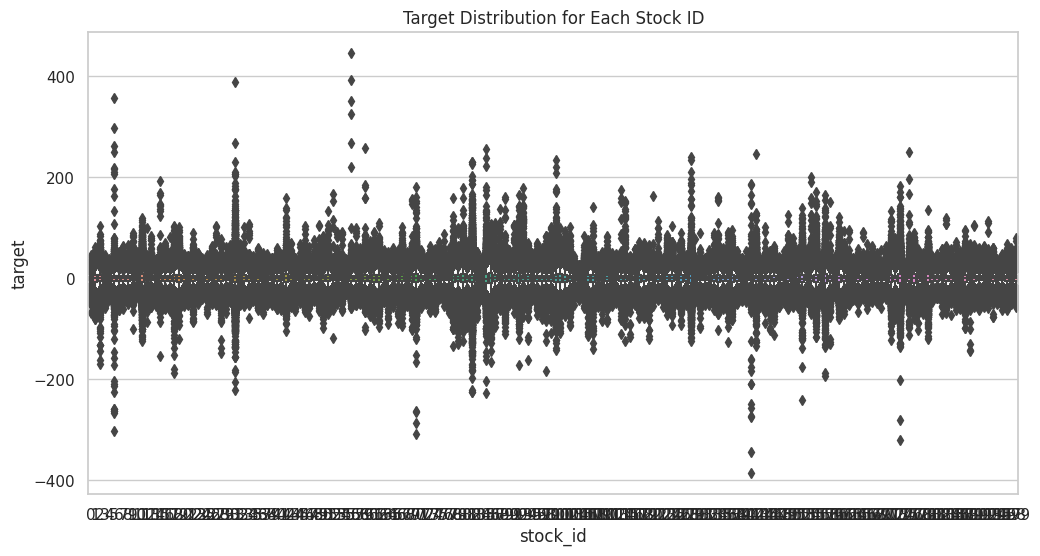

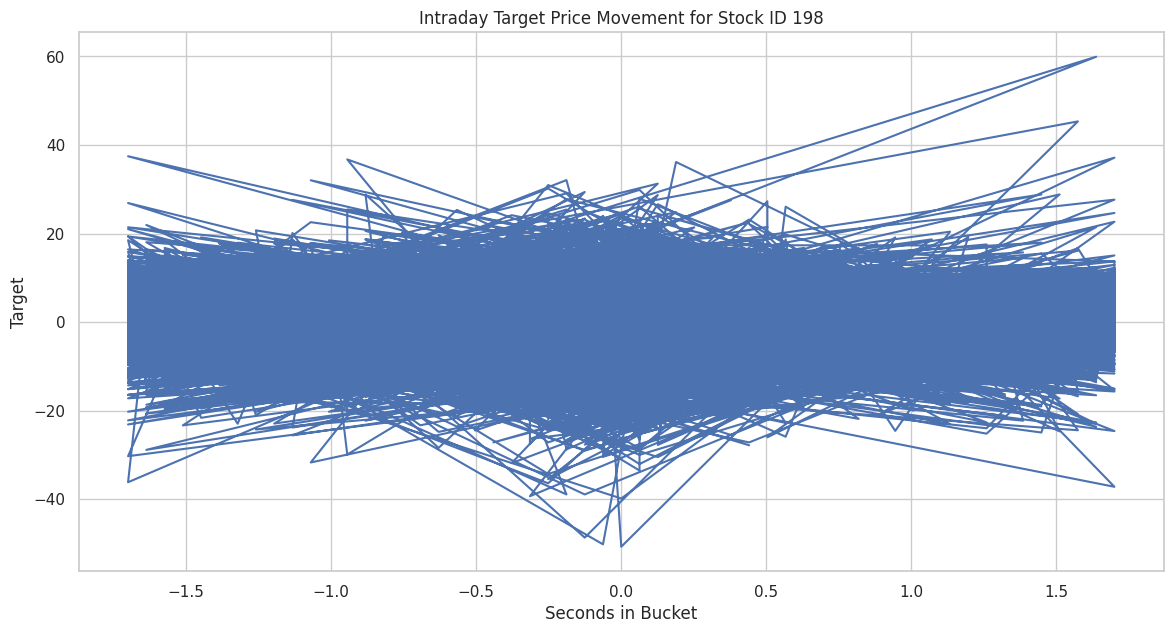

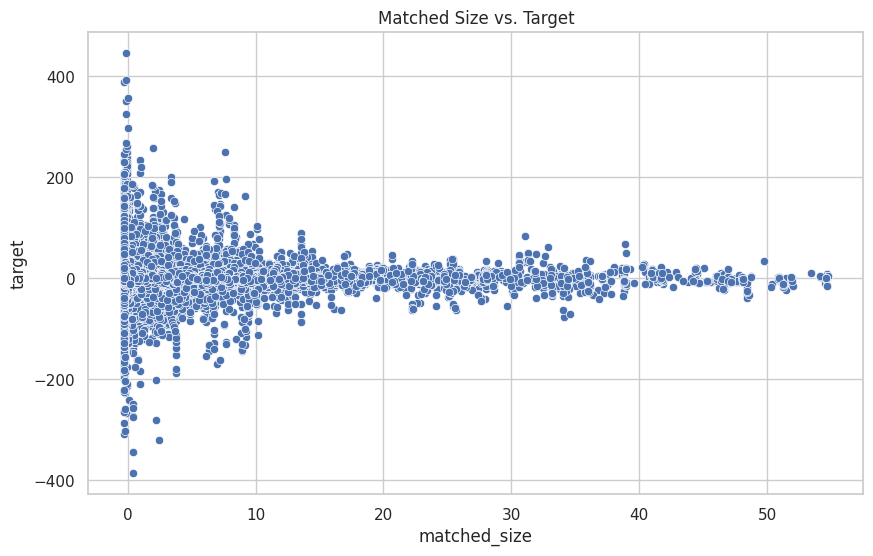

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt


# Assuming df has 'stock_id', 'seconds_in_bucket', 'matched_size', and 'target'
sns.set(style="whitegrid")

# Boxplot for stock_id vs target
plt.figure(figsize=(12, 6))
sns.boxplot(x='stock_id', y='target', data=df_train)
plt.title('Target Distribution for Each Stock ID')
plt.show()

# Time series plot for seconds_in_bucket vs target for a specific stock_id
plt.figure(figsize=(14, 7))
specific_stock = df_train[df_train['stock_id'] == some_stock_id]
plt.plot(specific_stock['seconds_in_bucket'], specific_stock['target'])
plt.title('Intraday Target Price Movement for Stock ID ' + str(some_stock_id))
plt.xlabel('Seconds in Bucket')
plt.ylabel('Target')
plt.show()

# Scatter plot for matched_size vs target
plt.figure(figsize=(10, 6))
sns.scatterplot(x='matched_size', y='target', data=df_train)
plt.title('Matched Size vs. Target')
plt.show()

## Insights from the Feature Importance Plot:

#### 1. Top Features:
1. According to the model, 'bid_ask_price_diff' is the most important feature. This suggests that the difference between the bid price and ask price is highly predictive of the target variable. This makes sense as a large spread usually indicates lower liquidity and higher trading costs, which can be critical in the decision-making process of trading.

2. 'matched_size' is the second most important feature. This could indicate that the amount that can be matched at the current referece price is crucial for predicting stock movement. High matched sizes could signal a consensus on price, leading to less volatility.

#### 2. Relative Importance
1. Features related to price ('bid_size', 'ask_size', 'near_price', 'far_price', etc) are all relatively important, which is intuitive given that they directly relate to the market dynamics of supply and demand.

#### 2.Scatter Plots for Individual Features vs Target:
scatter plots of features like 'wap', 'bid_price', 'ask_price' against the target variable over time can help visualize trends and anomalies.

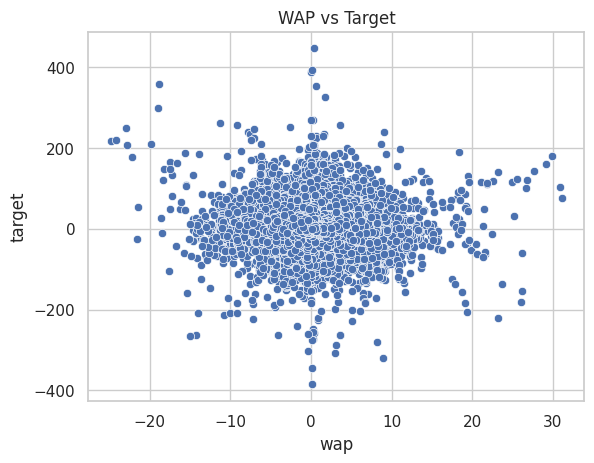

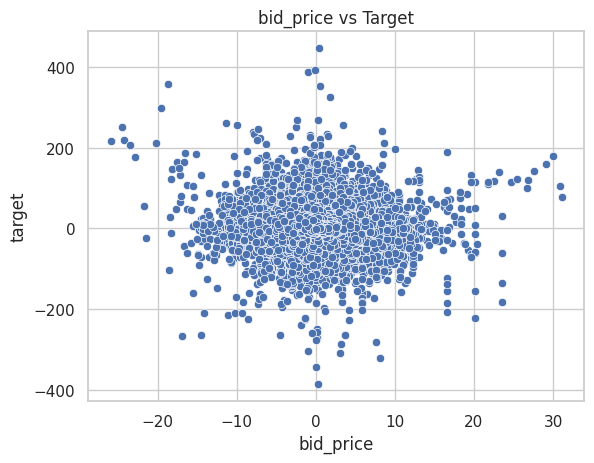

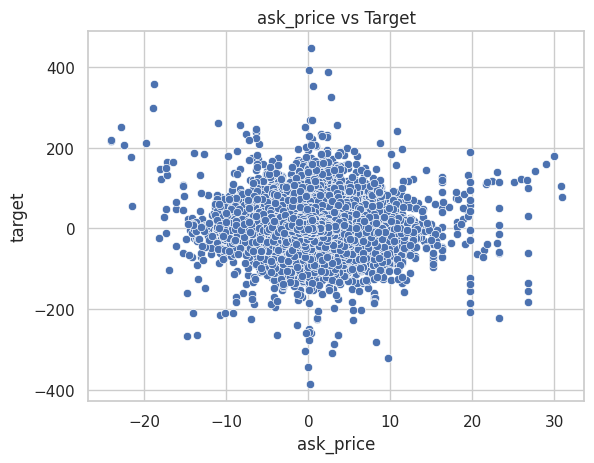

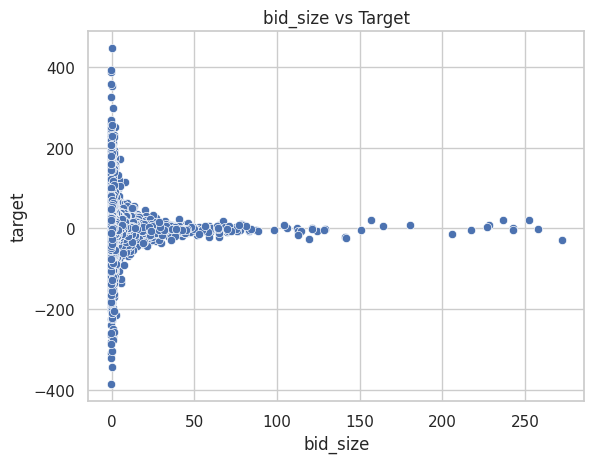

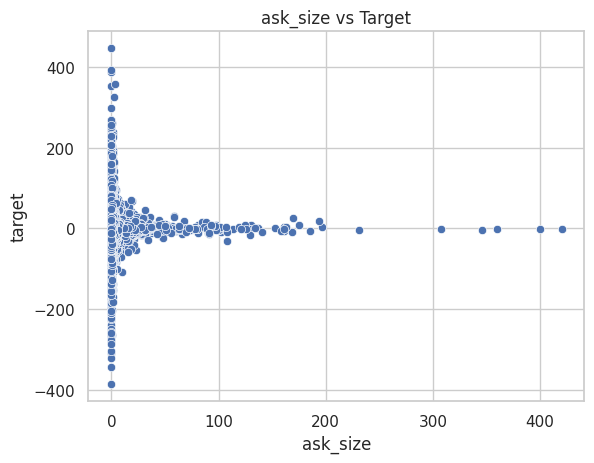

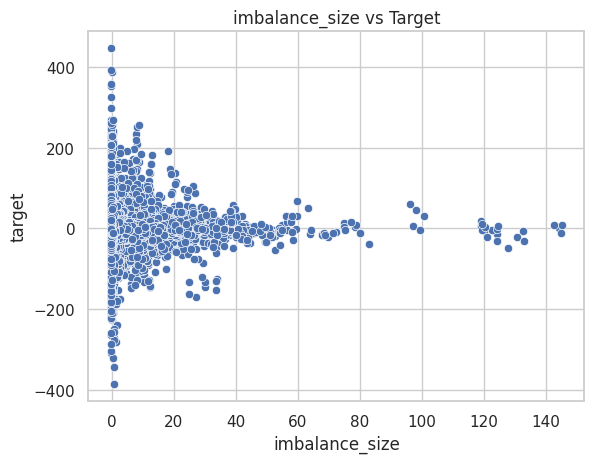

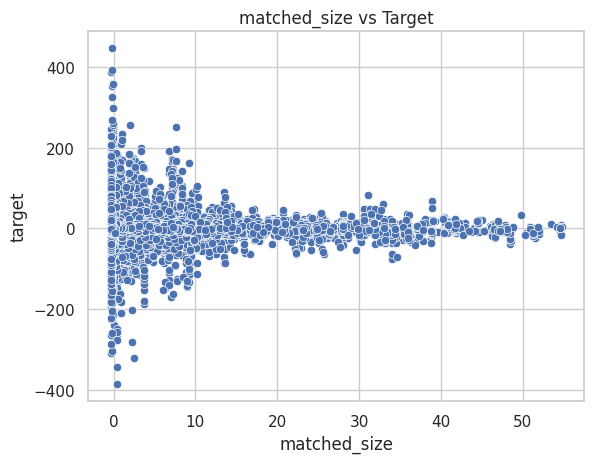

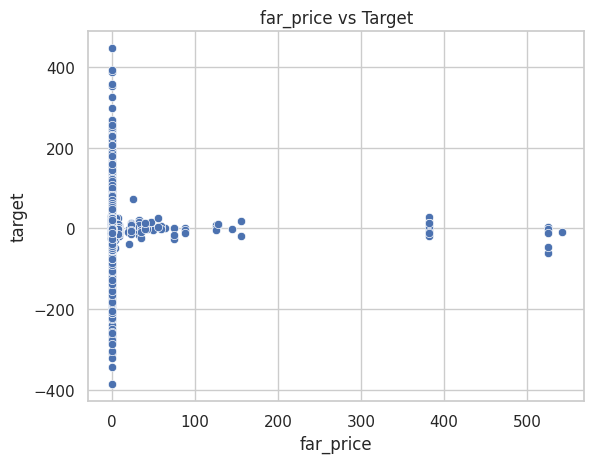

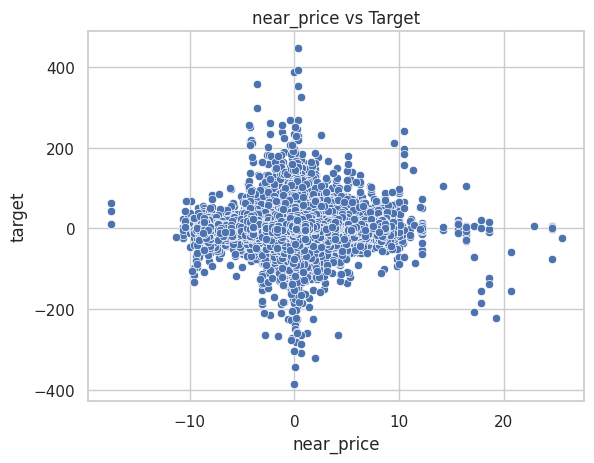

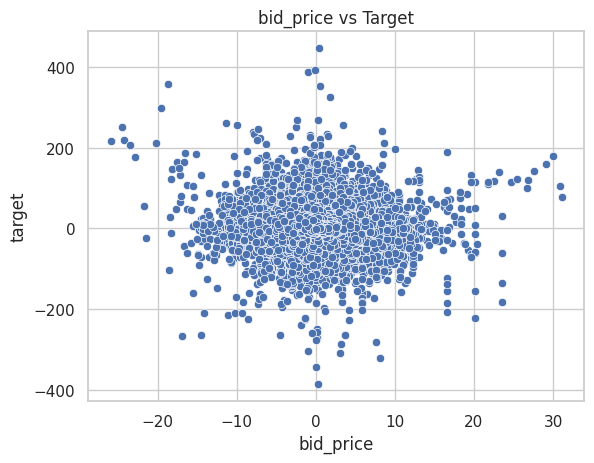

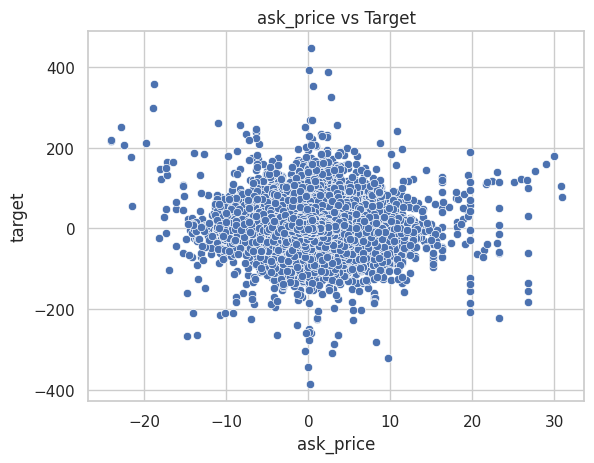

In [11]:
import seaborn as sns

# Example for 'wap' feature
sns.scatterplot(data=df_train, x='wap', y='target')
plt.title('WAP vs Target')
plt.show()

#Example for ask_price and Bid Price
sns.scatterplot(data = df_train, x = 'bid_price', y='target')
plt.title('bid_price vs Target')
plt.show()

sns.scatterplot(data = df_train, x = 'ask_price', y = 'target')
plt.title('ask_price vs Target')
plt.show()

#example for Bid size and Ask size
sns.scatterplot(data = df_train, x = 'bid_size', y='target')
plt.title('bid_size vs Target')
plt.show()

sns.scatterplot(data = df_train, x = 'ask_size', y='target')
plt.title('ask_size vs Target')
plt.show()


# example for imbalance size
sns.scatterplot(data = df_train, x = 'imbalance_size', y = 'target')
plt.title('imbalance_size vs Target')
plt.show()

# example for matched_size
sns.scatterplot(data = df_train, x = 'matched_size', y='target')
plt.title('matched_size vs Target')
plt.show()

# example for far_price
sns.scatterplot(data = df_train, x = 'far_price', y='target')
plt.title('far_price vs Target')
plt.show()

# example for near_price
sns.scatterplot(data = df_train, x = 'near_price', y='target')
plt.title('near_price vs Target')
plt.show()

# example for bid_price
sns.scatterplot(data = df_train, x = 'bid_price', y='target')
plt.title('bid_price vs Target')
plt.show()

# example for ask_price
sns.scatterplot(data = df_train, x = 'ask_price', y='target')
plt.title('ask_price vs Target')
plt.show()



#### 3.Correlation Heatmap
Since this model includes various features, a heatmap to visualize the correlation between different features can be insightful. This can help in understanding relationship between different market indicators.

<ipython-input-12-2d304f2eebee>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_train.corr()


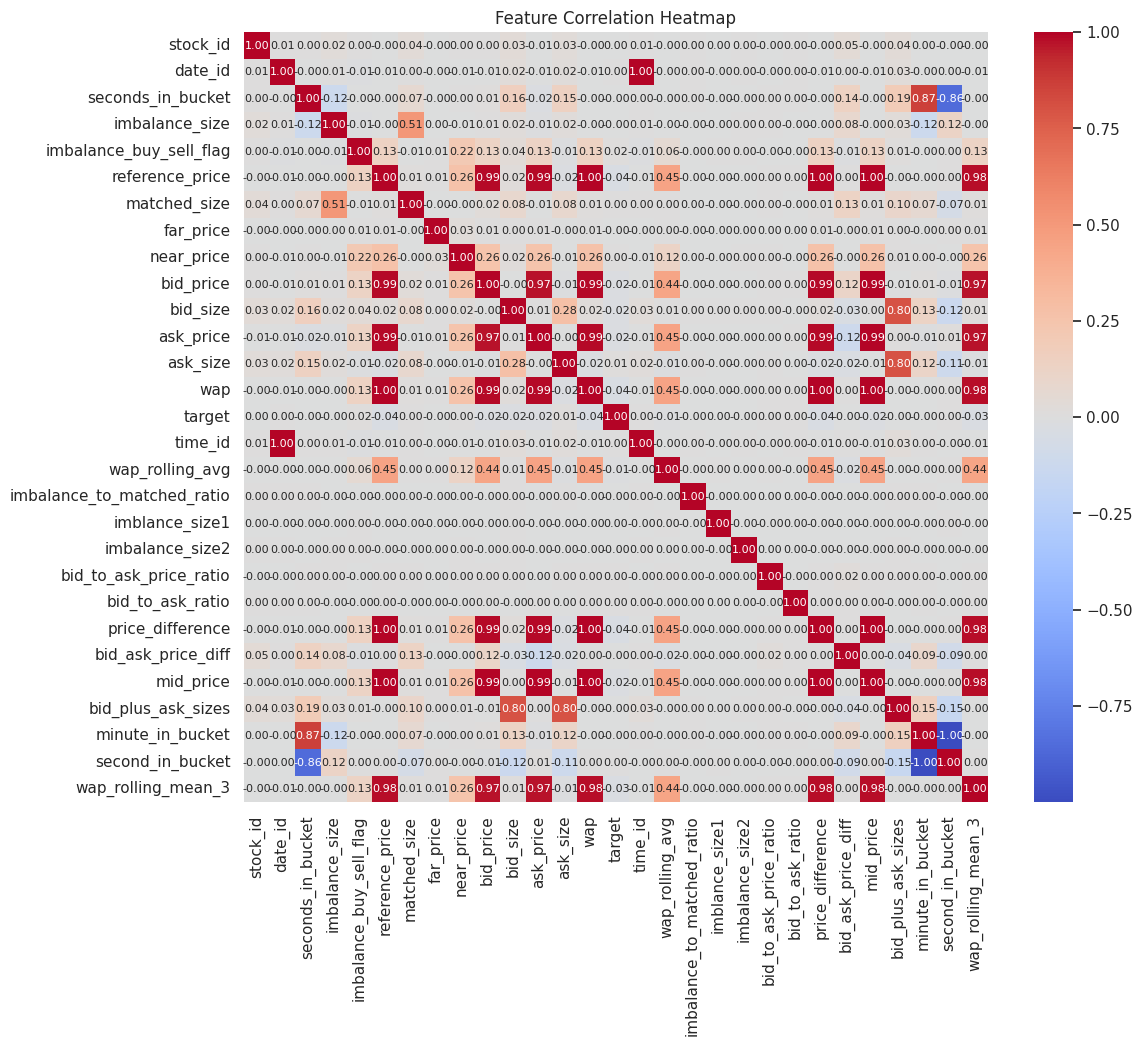

In [12]:
# Calculate correlation matrix
corr = df_train.corr()

# Create a larger figure for better readability
plt.figure(figsize=(12, 10))

# Create the heatmap with annotations
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', annot_kws={"size": 8})

# Set the title
plt.title('Feature Correlation Heatmap')

# Show the plot
plt.show()

#### 4.Time Series Plots
For time-based features like 'seconds_in_bucket', plotting these against the target can help visualize how the stock prices change over the course of the auction period.

In [19]:
which_stock = 50
y = df_train[df_train["stock_id"] == which_stock]["target"].copy()
x = df_train[df_train["stock_id"] == which_stock]["seconds_in_bucket"].copy()
df_plot = pd.DataFrame({'x': x, 'y': y})

df_plot.sort_values(by='x', inplace=True)

In [20]:
# if there are multiple values of a target at a single second, we took the median of these values
# this helps smooth out the graph

df_time = pd.DataFrame({'x':list(df_plot['x']), 'y': list(df_plot['y'])})
median_y = df_time.groupby('x')['y'].transform('median')
y_plot = median_y.tolist()


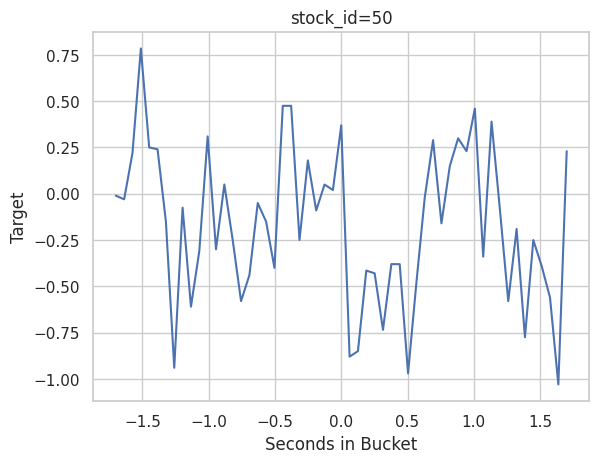

In [21]:
plt.plot(df_time['x'], y_plot)
plt.title(f'stock_id={which_stock}')
plt.xlabel('Seconds in Bucket')
plt.ylabel('Target')
plt.show()

#### 5.Histogram and Distribution Plots:
To understand the distribution of key features like 'imbalance_size', 'reference_price', and 'wap', histograms or density plots can be very useful.

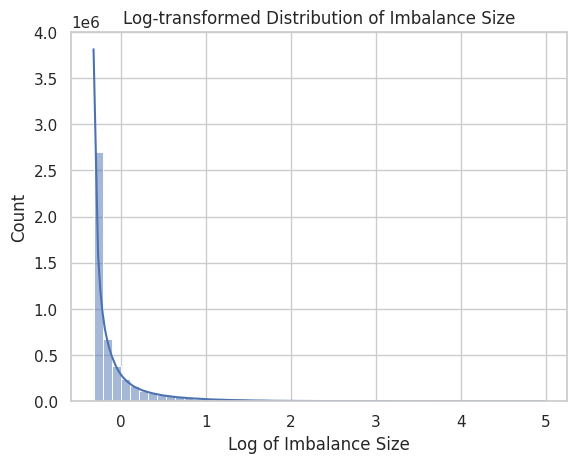

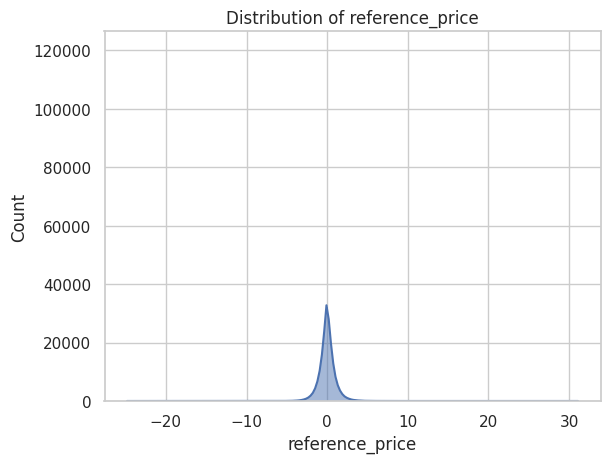

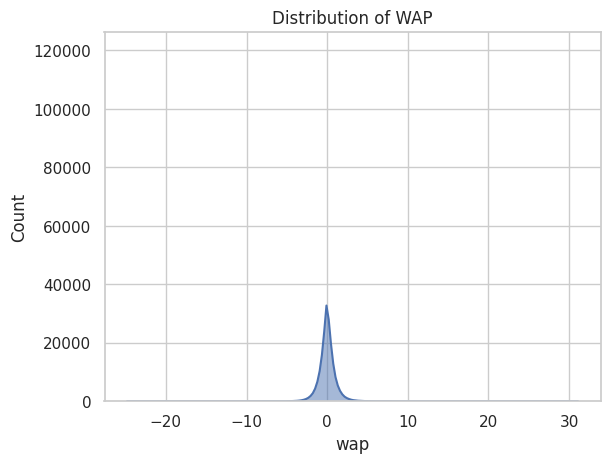

In [14]:
# histogram for imbalance size
# Log transformation with a small constant to handle values of zero
df_train['log_imbalance_size'] = np.log(df_train['imbalance_size'] + 1)

# Plotting the histogram with log-transformed data
sns.histplot(df_train['log_imbalance_size'], kde=True, bins=50)

# Set titles and labels
plt.title('Log-transformed Distribution of Imbalance Size')
plt.xlabel('Log of Imbalance Size')
plt.ylabel('Count')

# Display the plot
plt.show()
# histogram for reference_price
sns.histplot(df_train['reference_price'], kde=True)
plt.title('Distribution of reference_price')
plt.show()

# histogram for WAP
sns.histplot(df_train['wap'], kde = True)
plt.title('Distribution of WAP')
plt.show()

#### 8.Box Plots for Categorical Features:
When we have categorical features like 'stock_id', box plots can be useful to visualize the distribution of the target variable across different categories.

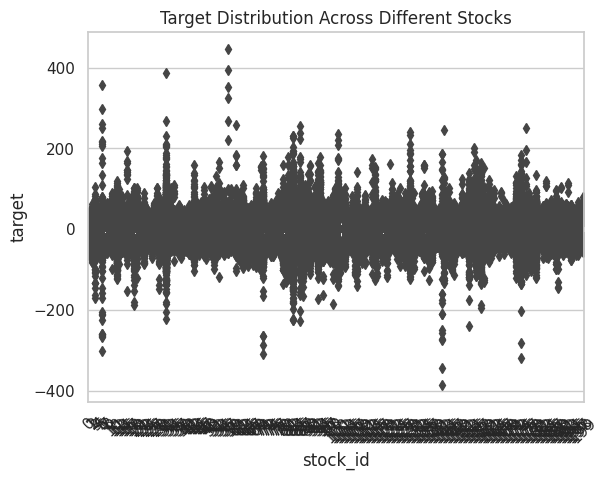

In [15]:
sns.boxplot(x='stock_id', y='target', data=df_train)
plt.title('Target Distribution Across Different Stocks')
plt.xticks(rotation=45)
plt.show()

<Axes: xlabel='stock_id', ylabel='target'>

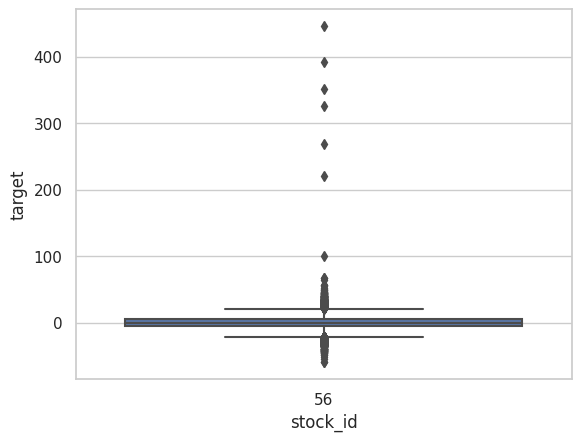

In [22]:
a = df_train[df_train['stock_id'].isin([56])]
sns.boxplot(data=a, x="stock_id", y="target")